In [1]:
import pandas as pd
from pandas import DataFrame as dframe
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import choice
from numpy import array as arr

import jax as j
cpu = j.devices("cpu")[0]
from jax import random, vmap
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro import sample, plate, param, deterministic
from numpyro.optim import Adam, Minimize
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import SVI, Trace_ELBO, init_to_value, Predictive

import utils
from utils import dotdict
from utils.data import data, scale
from utils.analysis import * # precis, cov2cor
from utils.stats import * # r::stats functions (rnorm, dnorm, ...)
from utils.plots import init_dag, scatter, shade
utils.init() # init plotting styles and hush warnings
seed = random.PRNGKey(42)

# Chapter 5 The Many Variables & The Spurious Waffles


In this chapter, we deal with spurious associations and multiple causes (that can hide one another). Adding more variables in your model can do harm. So in this chapter we begin to think formally about causal inference (graphical models, interpretive plots for regression models). Also introduced is the proper way to handle categorical variables.

### Code snippets

- Simple regression: plot prior lines (Code 5.4, Code 5.33 even cleaner)
- As of PyMC v5.2.0, use `pytensor.shared` to register exogenous variables (Code 5.19, 5.23).
- **Counterfactual plots (Code 5.22, 5.23).** Check `m5_3A` code, there was some nuance because some variable can be both a cause (that you might intervene later on) and an outcome (that you should declare as a random variable with observed values from the data, when you initially build the model and call `pm.sample()`). I don't think there is a straight forward way to reflect that in PyMC as of v5.2.0.
- Model checking plot: observed outcome v. predicted outcome, with error bars on each instance (Code 5.16)
- In a regression model, sampling the predicted mean response (given new inputs) is done via `pm.sample_posterior_predictive()`, & make sure to wrap `pm.Deterministic()` around the mean variable in the model definition code. 
- Plot seaborn regplot with your own PyMC model: Code 5.5, 5.6
- Compare the same parameter's posterior across different models: `az.plot_forest([trace1, trace2], var_names=["mu"])`. (Code 5.39)
- Categorical variables as index variables (Code 5.46-5.47)
- Contrast calculation in an `xr.Dataset` instance (`az.InfernceData.posterior`) and do `az.summary()` with the newly added contrast.

### Keywords
Markov equivalence, testable implications, contrast, spurious association, masked relationships, index variables.

## Section 5.1. Spurious associations

### Code 5.1 (read WaffleDivorce data)

Each data point represents a state. We care about the median age at marriage, marriage rate, and divorce rate of each state. But to start with, let's plot the number of waffle houses v. the divorce rate.

In [2]:
from sklearn.preprocessing import StandardScaler

WaffleDivorce = data("WaffleDivorce")
d = dframe()
d[["A", "M", "D"]] = scale(WaffleDivorce[["MedianAgeMarriage", "Marriage", "Divorce"]])
d.head()

,A,M,D
0,-0.606290,0.022644,1.654205
1,-0.686699,1.549802,1.544364
2,-0.204241,0.048974,0.610716
3,-1.410387,1.655123,2.093569
4,0.599857,-0.266989,-0.927058


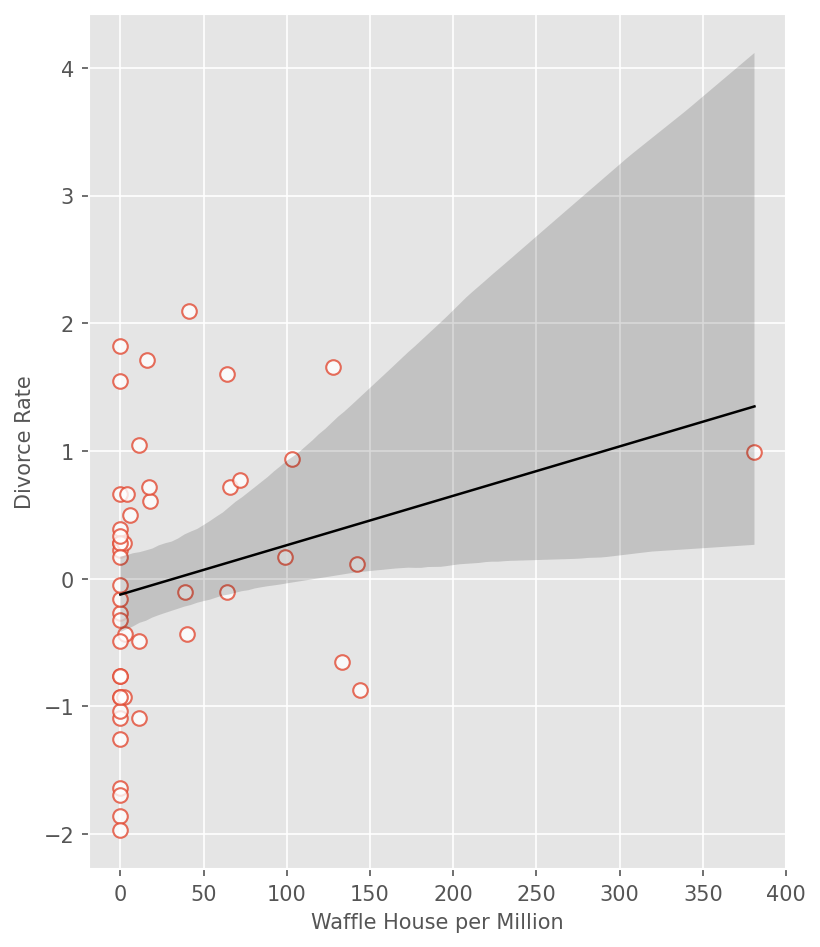

In [3]:
_, ax = plt.subplots(figsize=(6, 6))
sns.regplot(x=WaffleDivorce.WaffleHouses, y=d.D, scatter_kws={"color": "white", "edgecolors": "C0"}, line_kws={"color": "k"})
ax.set(xlabel="Waffle House per Million", ylabel="Divorce Rate");

Figure 5.1. The number of Waffle House diners per million people is associated with divorce rate (in the year 2009) within the United States.

### Code 5.2

In [5]:
WaffleDivorce.MedianAgeMarriage.std()

1.2436303013880823

### Code 5.3 (`m5_1`)

Sample prior slopes and plot for the simple regression `D ~ A`.

In [31]:
def f5_1(A, D):
    a = sample("a", dist.Normal(0, 0.2))
    bA = sample("bA", dist.Normal(0, 0.5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bA*A)
    sample("D", dist.Normal(mu, sigma), obs=D)
    
m5_1 = AutoLaplaceApproximation(f5_1)
priors = Predictive(f5_1, num_samples=50) \
                   (seed, A=d.A.values, D=None)
priors = dotdict(priors)

In [6]:
"""
with pm.Model() as m5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    A = shared(d.A.values)
    mu = pm.Deterministic("mu", a + bA*A)
    D = pm.Normal("D", mu, sigma, observed=d.D, shape=mu.shape)
    priors = pm.sample_prior_predictive().prior
    trace5_1 = pm.sample()
"""

Sampling: [D, a, bA, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Code 5.4 (prior slopes)

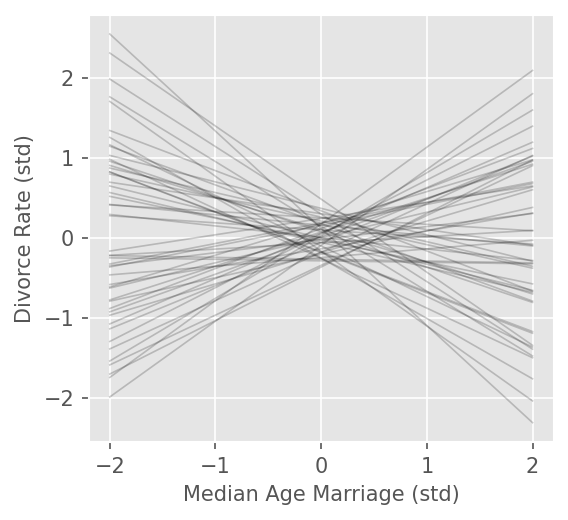

In [61]:
fig, ax = plt.subplots(figsize=(4, 3))

x = np.linspace(-2, 2, 50)

prior_samp_a = arr(priors.a)
prior_samp_bA = arr(priors.bA)

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.2)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)");

Figure 5.3: Plausible reglines implied by priors in `m5_1`.

### Code 5.5 (`m5_1` ppd and mean ppd plot)

In [62]:
p5_1 = (SVI(f5_1, m5_1, Adam(.1), Trace_ELBO())
             .run(seed, 2000, 
                  A=d.A.values, D=d.D.values)
             .params
       )
post5_1 = m5_1.sample_posterior(seed, p5_1, (1000,))

100%|████████████| 2000/2000 [00:00<00:00, 2300.54it/s, init loss: 121.3929, avg. loss [1901-2000]: 60.6515]


In [74]:
A_seq = jnp.linspace(-3, 3.2, 30)
mu = Predictive(f5_1, post5_1)(seed, A=A_seq, D=None)["mu"]
mu_PI = hpdi(mu, .89)

fig, ax = plt.subplots(1, 2)
ax[1].scatter(x=d.A, y=d.D, c="white", edgecolors="C0", s=50)
ax[1].plot(A_seq, mu.mean(0), color="k")
ax[1].fill_between(A_seq, mu_PI[0], mu_PI[1], color="C3", alpha=0.2)
ax[1].set_xlabel("Age at Marriage")
ax[1].set_ylabel("Divorce Rate")
plt.close() 

In [ ]:
"""
with m5_1:
    A_seq = np.linspace(-3, 3.2, 30)
    A.set_value(A_seq)
    ppd = pm.sample_posterior_predictive(trace5_1, var_names=["mu"]).posterior_predictive
    mu_mean = ppd.mu.mean(("chain", "draw"))
"""

### Code 5.6 (`m5_2`)

Model `D ~ M`.

In [75]:
def f5_2(M, D):
    a = sample("a", dist.Normal(0, 0.2))
    bM = sample("bM", dist.Normal(0, 0.5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bM*M)
    sample("D", dist.Normal(mu, sigma), obs=D)
    
m5_2 = AutoLaplaceApproximation(f5_2)
p5_2 = (SVI(f5_2, m5_2, Adam(.1), Trace_ELBO())
           .run(seed, 2000, 
                M=d.M.values, D=d.D.values)
           .params)

100%|████████████| 2000/2000 [00:00<00:00, 2854.68it/s, init loss: 237.0699, avg. loss [1901-2000]: 67.4809]


In [ ]:
"""
with pm.Model() as m5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    M = shared(d.M.values)
    mu = pm.Deterministic("mu", a + bM*M)
    D = pm.Normal("D", mu, sigma, observed=d.D, shape=mu.shape)
    trace5_2 = pm.sample()
"""

#### Plotting Figure 5.2

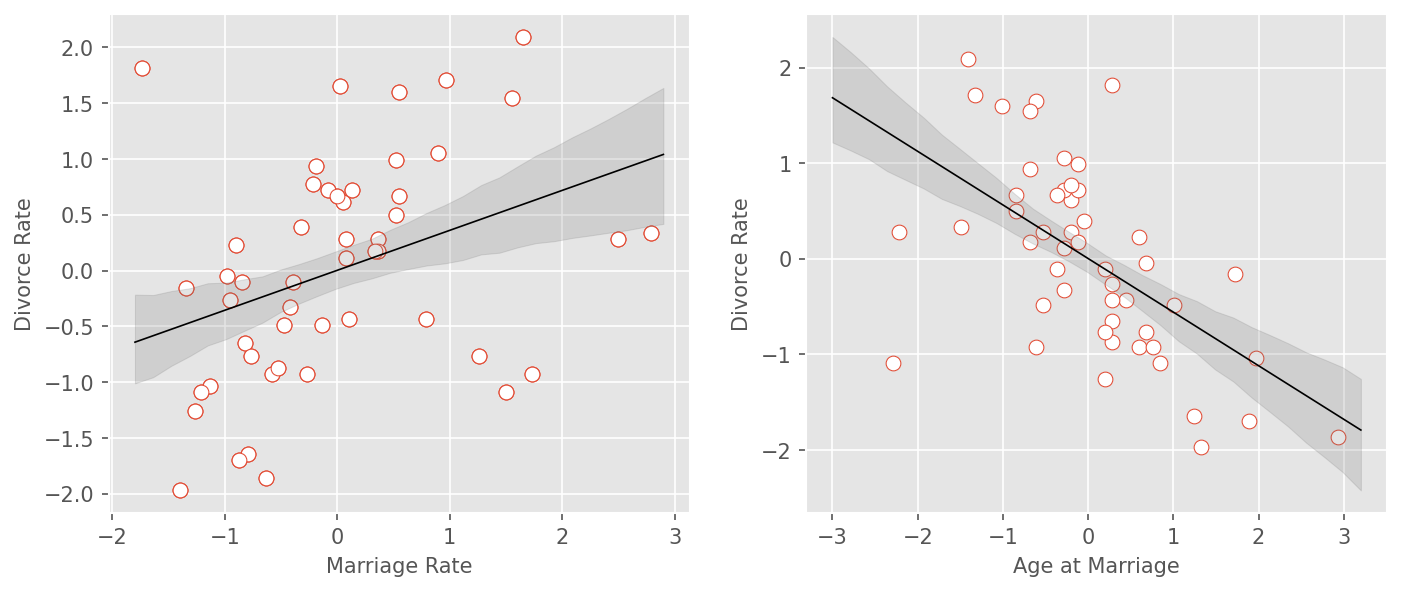

In [79]:
post5_2 = m5_2.sample_posterior(seed, p5_2, (1000,))
M_seq = jnp.linspace(-1.8, 2.9, 30)
mu = Predictive(f5_2, post5_2) \
               (seed, M=M_seq, D=None)["mu"]
mu_PI = hpdi(mu, .89)

ax[0].scatter(x=d.M, y=d.D, c="white", edgecolors="C0", s=50)
ax[0].plot(M_seq, mu.mean(0), color="k")
ax[0].fill_between(M_seq, mu_PI[0], mu_PI[1],
                   color="C3", alpha=.2)
ax[0].set_xlabel("Marriage Rate")
ax[0].set_ylabel("Divorce Rate")
fig

Figure 5.2 (left). Fitted line and shade is a simple Bayesian regression of marriage rate v. divorce. 

Figure 5.2 (right). Fitted line and shade is a simple Bayesian regression of age v. divorce.

### Code 5.7 (`dag5_1`)

Think before you regress (5.1.1). Here is one possible causal model plotted. Try to think of plausible explanations why this causal model could be true. Try to explain each of the arrows.

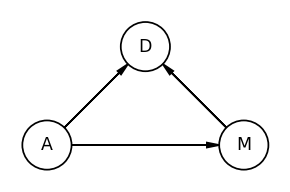

In [92]:
dag5_1 = init_dag()
dag5_1.add_node("A", "A", 0, 0)
dag5_1.add_node("D", "D", 1, 1)
dag5_1.add_node("M", "M", 2, 0)
dag5_1.add_edge("A", "D")
dag5_1.add_edge("A", "M")
dag5_1.add_edge("M", "D")
dag5_1.show();

From `m5_2` we know that M is positively associated with D, but that doesn't mean `M -> D`. The causal model below can also be true given what we know from `m5_1` and `m5_2`: 

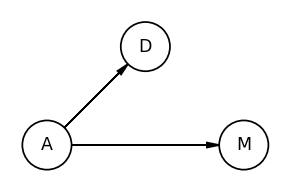

In [93]:
dag5_1a = init_dag()
dag5_1a.add_node("A", "A", 0, 0)
dag5_1a.add_node("D", "D", 1, 1)
dag5_1a.add_node("M", "M", 2, 0)
dag5_1a.add_edge("A", "D")
dag5_1a.add_edge("A", "M")
dag5_1a.show();

How do we use data to compare multiple, plausible causal models? The first thing to consider are the **testable implications** (5.1.2) of each causal model. 

Any DAG may imply some conditional independences. Let's look for them in `dag5_1a`. We do have one there, which is D_||_M | A. `dag5_1` on the other hand does not have this implication.

To test this implication, we need a statistical model that conditions on A, and see whether that renders D independent of A. That's where multiple regression comes in. We normally see a lot of parameter estimation results from regression models, but it is only when we answer an implication like D_||_M | A, there is causal meaning in the regression results.

### Code 5.8 - 5.9 (skipped)

Given a graphical model, return the implied conditional independencies via `dagitty::impliedConditionalIndependencies` in R.

### Code 5.10 (`m5_3`)
Modeling `D ~ A + M`

In [109]:
def f5_3(A, M, D):
    a = sample("a", dist.Normal(0, 0.2))
    bM = sample("bM", dist.Normal(0, 0.5))
    bA = sample("bA", dist.Normal(0, 0.5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bM*M + bA*A)
    D = sample("D", dist.Normal(mu, sigma), obs=D)
    
m5_3 = AutoLaplaceApproximation(f5_3)
p5_3 = (SVI(f5_3, m5_3, Adam(.1), Trace_ELBO())
           .run(seed, 4000, 
                A=d.A.values, M=d.M.values, D=d.D.values
               ).params
       )
post5_3 = m5_3.sample_posterior(seed, p5_3, (1, 1000))
precis(post5_3, pars=["a", "bM", "bA", "sigma"])

100%|████████████| 4000/4000 [00:01<00:00, 3047.33it/s, init loss: 122.1747, avg. loss [3801-4000]: 60.7888]


,mean,sd,5.5%,94.5%
a,-0.00,0.10,-0.16,0.16
bM,-0.07,0.15,-0.30,0.17
bA,-0.61,0.15,-0.84,-0.37
sigma,0.79,0.08,0.67,0.91


In [ ]:
"""
with pm.Model() as m5_3:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM*d.M + bA*d.A)
    D = pm.Normal("D", mu, sigma, observed=d.D)
    trace5_3 = pm.sample()
precis(trace5_3, pars=["a", "bM", "bA", "sigma"])
"""

### Code 5.11 (`az.plot_forest` with multiple models)

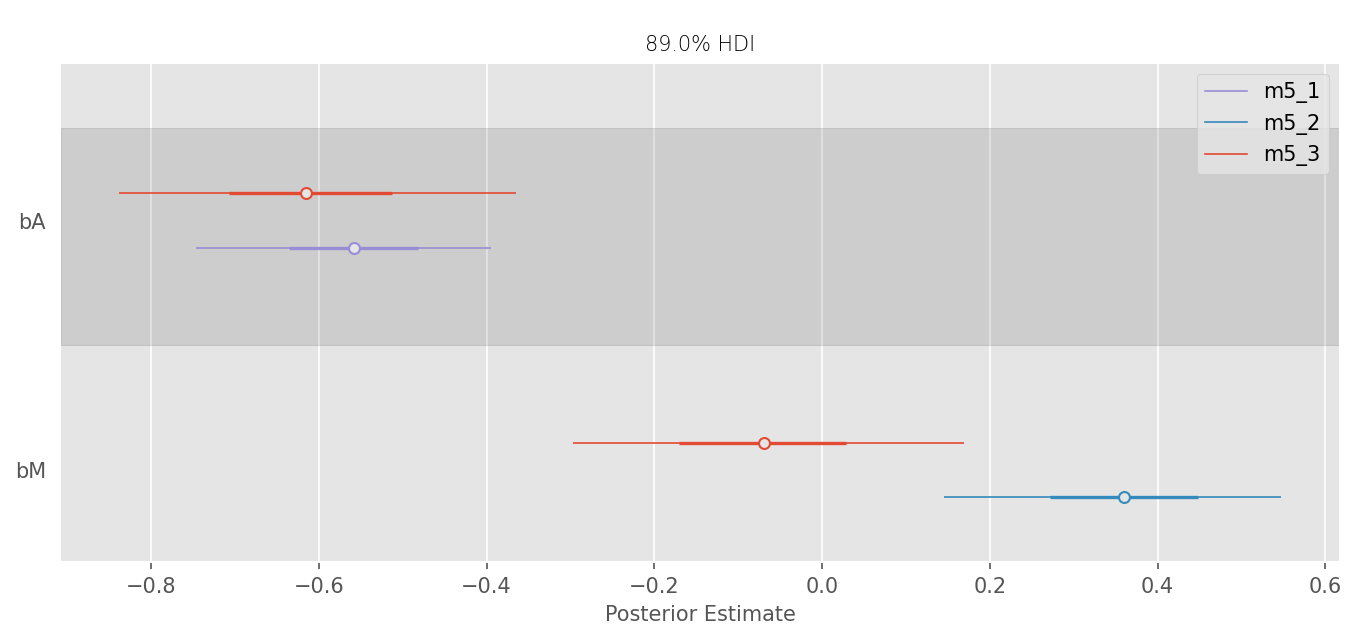

In [112]:
post5_1 = m5_1.sample_posterior(seed, p5_1, (1, 1000))
post5_2 = m5_2.sample_posterior(seed, p5_2, (1, 1000))

ax = plt.subplot()
az.plot_forest([post5_3, post5_2, post5_1],
    model_names=["m5_3", "m5_2", "m5_1"],
    var_names=["bA", "bM"],
    combined=True,
    ax=ax
)
ax.set(xlabel="Posterior Estimate");

The model `m5_3` with two predictors is able to discover which predictor has more association with the outcome. More importantly, it proves the implication D_||_M | A. Hence, we not only conclude that there is no value including the `M` variable for prediction purposes once we know 'A', but also rule out `dag5_1`. (5.1.2). But how did `m5_3` acheive the inference that adding `M` adds no extra information once we know `A`? Let's draw some pictures (5.1.5) 

### Code 5.12 (spurious association simulation)
Overthinking: simulating the divorce example (spurious association)

In [113]:
N = 50
age = rnorm(N)
mar = rnorm(N, -age) # A -> M
div = rnorm(N, age) # A -> D

In [115]:
p5_1_ = (SVI(f5_1, m5_1, Adam(.1), Trace_ELBO())
            .run(seed, 2000, A=age, D=div).params
        )
post5_1_ = m5_1.sample_posterior(seed, p5_1_, (1, 1000))

p5_2_ = (SVI(f5_2, m5_2, Adam(.1), Trace_ELBO())
            .run(seed, 2000, M=mar, D=div).params
        )
post5_2_ = m5_2.sample_posterior(seed, p5_2_, (1, 1000))

p5_3_ = (SVI(f5_3, m5_3, Adam(.1), Trace_ELBO())
            .run(seed, 2000, A=age, M=mar, D=div).params
        )
post5_3_ = m5_3.sample_posterior(seed, p5_3_, (1, 1000))

100%|████████████| 2000/2000 [00:00<00:00, 2691.72it/s, init loss: 120.3371, avg. loss [1901-2000]: 63.4432]


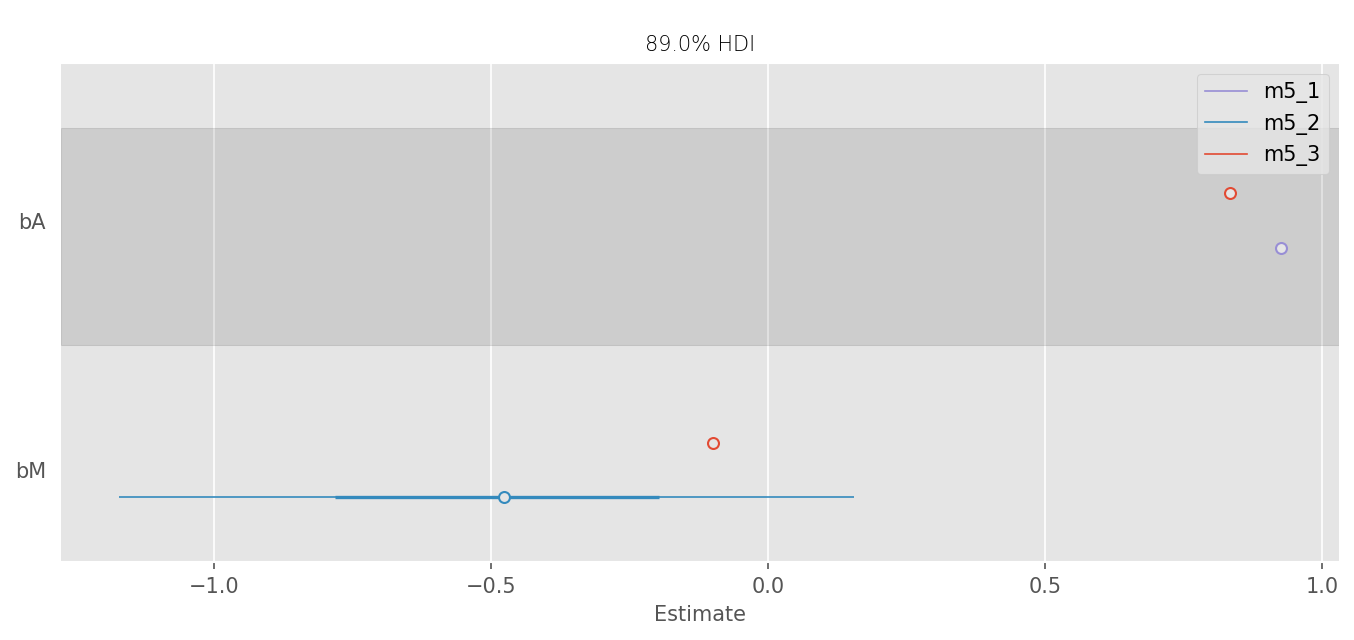

In [116]:
ax = plt.subplot()
az.plot_forest([post5_3_, post5_2_, post5_1_],
    model_names=["m5_3", "m5_2", "m5_1"],
    var_names=["bA", "bM"],
    combined=True,
    ax=ax
)
ax.set(xlabel="Estimate");

Interpreting coefficients in a multiple regression will depend on what you believe about the causal model, because many causal models are consistent with one set of parameter estimates. Later discussed under the name **Markov equivalence**.

### Code 5.13 (`m5_4`)
Modeling `M ~ A`

In [117]:
def f5_4(A, M):
    a = sample("a", dist.Normal(0, 0.2))
    bAM = sample("bAM", dist.Normal(0, 0.5))
    mu = deterministic("mu", a + bAM*A)
    sigma = sample("sigma", dist.Exponential(1))
    sample("M", dist.Normal(mu, sigma), obs=M)
    
m5_4 = AutoLaplaceApproximation(f5_4)
p5_4 = (SVI(f5_4, m5_4, Adam(.1), Trace_ELBO())
           .run(seed, 2000, 
                A=d.A.values, M=d.M.values)
           .params
       )

100%|████████████| 2000/2000 [00:00<00:00, 3061.02it/s, init loss: 106.6371, avg. loss [1901-2000]: 53.6927]


In [ ]:
"""
with pm.Model() as m5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    mu = pm.Deterministic("mu", a + bAM*d.A)
    sigma = pm.Exponential("sigma", 1)
    M = pm.Normal("M", mu=mu, sigma=sigma, observed=d.M)
    trace5_4 = pm.sample()
"""

### Code 5.14 (get `M` residuals)

In [121]:
post5_4 = m5_4.sample_posterior(seed, p5_4, (1, 1000))
mu = Predictive(f5_4, post5_4, batch_ndims=2) \
               (seed, A=d.A.values, M=None)["mu"]
M_resid = d.M.values - mu.mean([0, 1])

#### Plotting Figure 5.4 (predictor residuals v. outcome)

In [126]:
def f5_4A(M, A):
    a = sample("a", dist.Normal(0, 0.2))
    bMA = sample("bMA", dist.Normal(0, 0.5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bMA*M)
    sample("A", dist.Normal(mu, sigma), obs=A)
    
m5_4A = AutoLaplaceApproximation(f5_4A)
p5_4A = (SVI(f5_4A, m5_4A, Adam(.1), Trace_ELBO())
            .run(seed, 2000, M=d.M.values, A=d.A.values)
            .params)
post5_4A = m5_4A.sample_posterior(seed, p5_4A, (1, 1000))
mu = Predictive(f5_4A, post5_4A, batch_ndims=2) \
               (seed, M=d.M.values, A=None)["mu"]
A_resid = d.A.values - mu.mean([0, 1])

100%|████████████| 2000/2000 [00:00<00:00, 2957.11it/s, init loss: 106.6371, avg. loss [1901-2000]: 53.6927]


In [ ]:
"""
with pm.Model() as m5_4A:
    a = pm.Normal("a", 0, 0.2)
    bMA = pm.Normal("bMA", 0, 0.5)
    mu = pm.Deterministic("mu", a + bMA*d.M)
    sigma = pm.Exponential("sigma", 1)
    A = pm.Normal("A", mu=mu, sigma=sigma, observed=d.A)
    trace5_4A = pm.sample()
    mu_ppd = pm.sample_posterior_predictive(trace5_4A, var_names=["mu"]).posterior_predictive.mu
    mu_mean = mu_ppd.mean(("chain", "draw"))
    A_resid = d.A - mu_mean
"""

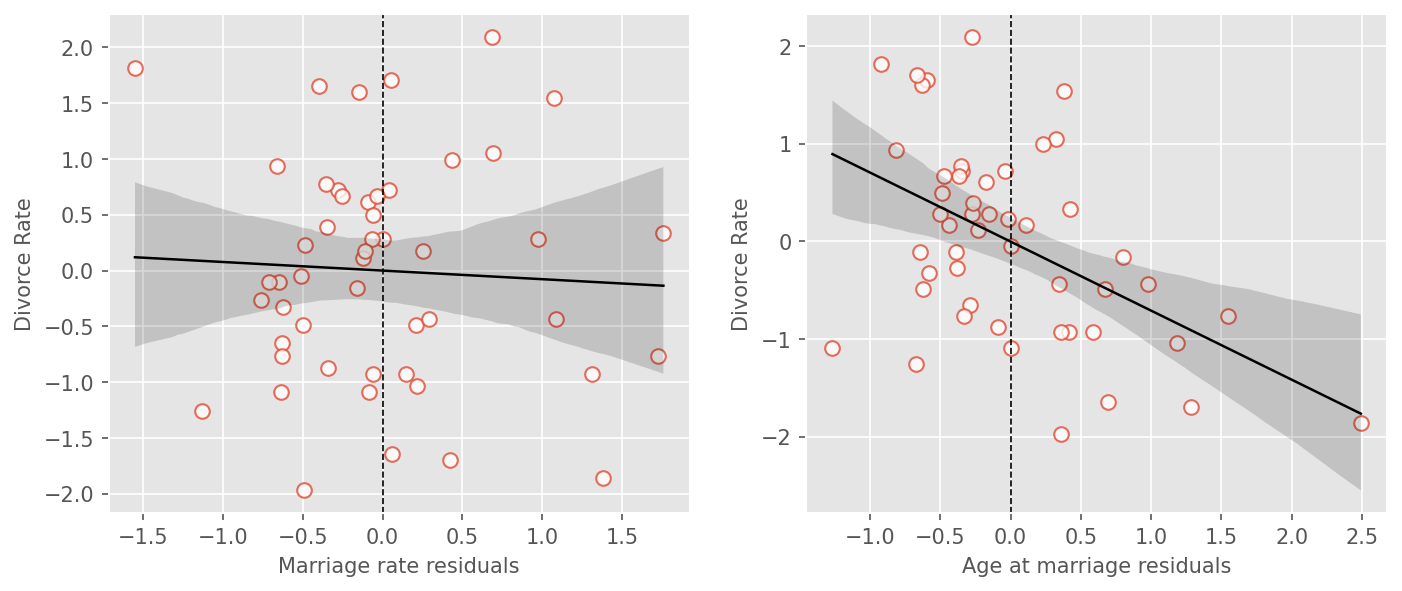

In [129]:
_, ax = plt.subplots(1, 2)
ax[0].axvline(0, color="k", linestyle="--")
sns.regplot(x=M_resid, y=d.D, ax=ax[0], scatter_kws={"color": "white", "edgecolors": "C0"}, line_kws={"color": "k"})
ax[0].set(xlabel="Marriage rate residuals", ylabel="Divorce Rate");

ax[1].axvline(0, color="k", linestyle="--")
sns.regplot(x=A_resid, y=d.D, ax=ax[1], scatter_kws={"color": "white", "edgecolors": "C0"}, line_kws={"color": "k"})
ax[1].set(xlabel="Age at marriage residuals", ylabel="Divorce Rate");

Figure 5.4. The predictor residuals are from the model with the other predictor as the regressor (think of each plot as the association between this predictor and the outcome, statistically controlled for the other predictor). 

- Left: the marriage rate residuals are not associated with divorce rate. The vertical dashed line indicates when the marriage rate is as expected given the age at marriage. (**but states on the vertical line might have different age at marriage**) When marriage rate is unexpectedly higher or lower, divorce rate does not change significantly.

- Right: the age at marriage residuals are negatively associated with divorce rate. Apply the same procedure of analysis, we can conclude: states where people marry older than expected for a given marriage rate tend to have less divorce.

### Code 5.15 (`m5_3` ppd)

In [146]:
# use original data to estimate posterior mu
post_pred = Predictive(f5_3, post5_3, batch_ndims=2) \
                      (seed, A=d.A.values, 
                       M=d.M.values, D=None)
mu = post_pred["mu"]
mu = mu.reshape((-1, mu.shape[-1]))
mu_mean = mu.mean(0)
mu_PI = hpdi(mu, .89)

# use original data to simulate observations
D = post_pred["D"]
D = D.reshape((-1, D.shape[-1]))
D_mean = D.mean([0, 1])
D_PI = hpdi(D, .89)

### Code 5.16 (obs v. `m5_3` pred)

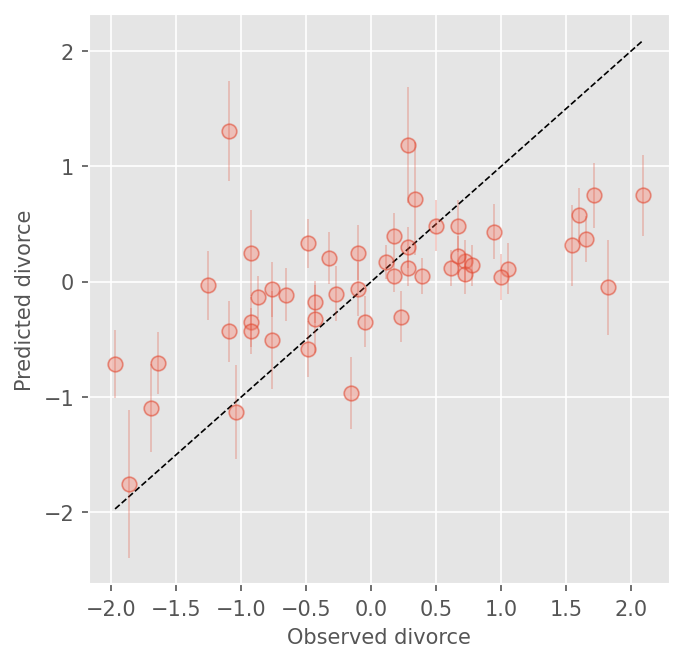

In [151]:
_, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x=d.D, y=mu_mean, edgecolor="C0", color="w", alpha=0.5);
min_x, max_x = d.D.min(), d.D.max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

plt.errorbar(d.D, mu_mean,
    yerr=np.abs(mu_mean - mu_PI[0]),
    fmt="o", alpha=0.3
)

ax.set(xlabel="Observed divorce", ylabel="Predicted divorce"); 

Figure 5.5: observed v. posterior prediction for `m5_3`. Error bars indicate the 89% compatibility intervals for each prediction.

Note that the model underpredicts those states with extremely high divorce rates, and overpredicts those with extremely low divorce rates. That's normal. Regression models tend to be skeptical of extreme values. Apart from that, there are some cases where the divorce rate is not extreme, but the model goes far off from the true value. Notably Idaho and Utah (not shown in my plot above, but can be found in the original Figure 5.5 of the book). Well these two states happen to have a lot of Mormons, and Mormons tend not to divorce. This suggests having more features would help to refine our understanding.

### Code 5.17 (Python counterpart not found)

In [24]:
#identify( x=d$D , y=mu_mean , labels=d$Loc )
# hover cursor to a point in a plot, then R returns the corresponding value for that point (name of State)

### Code 5.18 (simulating)
Overthinking: simulating the spurious association

In [152]:
N = 100
x_real = rnorm(N)
x_spur = rnorm(N, mu=x_real)
y = rnorm(N, mu=x_real)

### Code 5.19 (`m5_3A`)

It is tempting to just change one predictor and see the change in the outcome. But taking our `dag5_1` as a given, changing A also changes M, which in turn influences any change in D. Model `m5_3` ignored the assumption that A influences M. So we need another statistical model to reflect `dag5_1`.

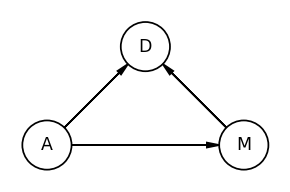

In [155]:
dag5_1.show();

In [2]:
WaffleDivorce = data("WaffleDivorce")
d = dframe()
d[["A", "D", "M"]] = scale(WaffleDivorce[["MedianAgeMarriage", "Divorce", "Marriage"]])

def f5_3A(A, M, D):
    # A -> M
    aM = sample("aM", dist.Normal(0, 0.2))
    bAM = sample("bAM", dist.Normal(0, 0.5))
    sigma_M = sample("sigma_M", dist.Exponential(1))
    mu_M = deterministic("mu_M", aM + bAM*A)
    M = sample("M", dist.Normal(mu_M, sigma_M), obs=M)
    
    # A -> D <- M
    a = sample("a", dist.Normal(0, 0.2))
    bM = sample("bM", dist.Normal(0, 0.5))
    bA = sample("bA", dist.Normal(0, 0.5))
    sigma_D = sample("sigma_D", dist.Exponential(1))
    mu_D = deterministic("mu_D", a + bM*M + bA*A)
    sample("D", dist.Normal(mu_D, sigma_D), obs=D)
    
    
m5_3A = AutoLaplaceApproximation(f5_3A)
p5_3A = (SVI(f5_3A, m5_3A, Adam(.1), Trace_ELBO())
            .run(seed, 2000, 
                 A=d.A.values, M=d.M.values, D=d.D.values)
            .params)
n_samples = 1000
post5_3A = m5_3A.sample_posterior(seed, p5_3A, (1, n_samples))
precis(post5_3A, pars=["bAM", "bM", "bA"])

100%|███████████████████████| 2000/2000 [00:01<00:00, 1770.69it/s, init loss: 234.3279, avg. loss [1901-2000]: 114.4805]


,mean,sd,5.5%,94.5%
bAM,-0.69,0.09,-0.85,-0.55
bM,-0.06,0.15,-0.29,0.20
bA,-0.61,0.15,-0.85,-0.39


In [ ]:
"""
with pm.Model() as m5_3A:
    M = shared(d.M.values)
    A = shared(d.A.values)
    # A -> M
    aM = pm.Normal("aM", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma_M = pm.Exponential("sig_M", 1)
    mu_M = aM + bAM*A
    M_rv = pm.Normal("M_rv", mu_M, sigma_M, observed=d.M.values, shape=mu_M.shape)
    
    # A -> D <- M
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sig", 1)
    mu_D = a + bM*M_rv + bA*A
    D_rv = pm.Normal("D", mu_D, sigma, observed=d.D.values, shape=mu_D.shape)
    trace5_3A = pm.sample()
"""

Looking at the summary table, we know that A and M are negatively associated. If interpreting causally, this means increasing A reduces M.

### Code 5.20 (intervention of `A`)

Next, we see **what would happen if we manipulate A**. 

In [3]:
A_seq = jnp.linspace(-2, 2, 50)

### Code 5.21 (`m5_3A` ppd with intervened `A`)

In [4]:
post_pred = dotdict( 
            Predictive(f5_3A, post5_3A, batch_ndims=2) \
                      (seed, A=A_seq, M=None, D=None)
)

### Code 5.22 (`m5_3A` counterfactual plots for `A`)

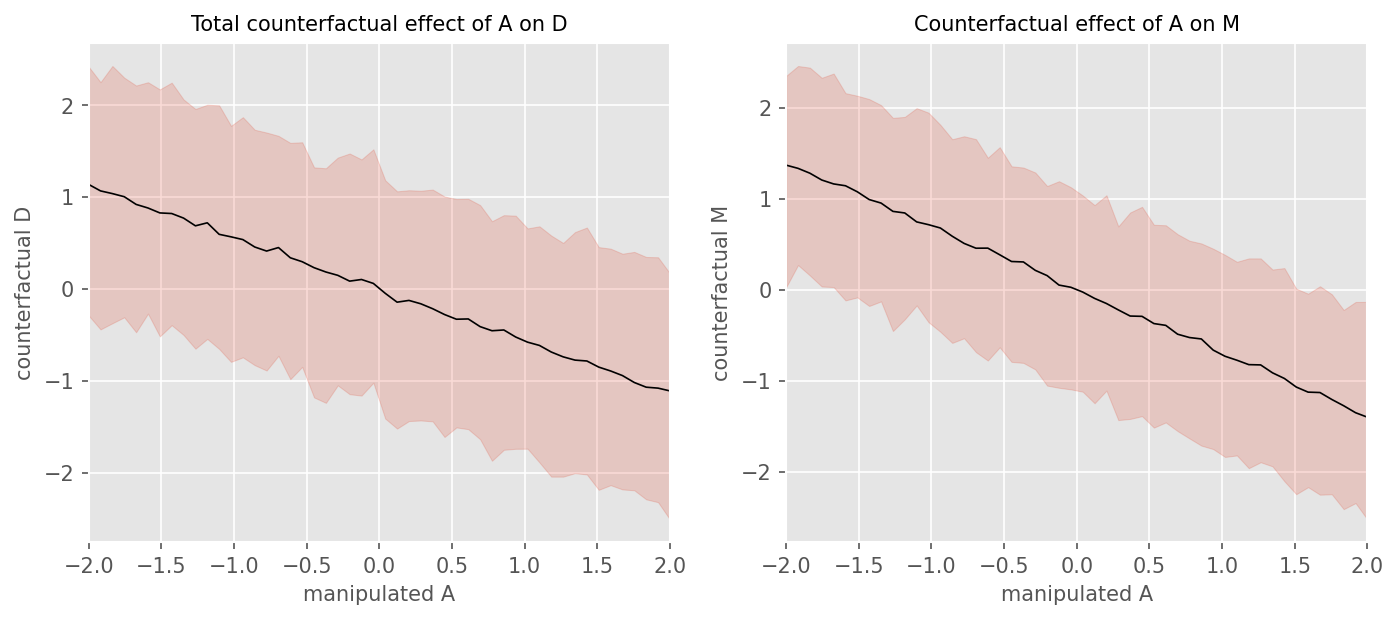

In [7]:
M, D = post_pred["M"].squeeze(0), post_pred["D"].squeeze(0)
M_PI, D_PI = hpdi(M, .89), hpdi(D, .89)

# counterfactual plot A (-> M) -> D
_, ax = plt.subplots(1, 2)
ax[0].plot(A_seq, D.mean(0), color="k")
shade(A_seq, D_PI, ax=ax[0], color="C0", alpha=0.2)
ax[0].set(xlim=[-2, 2], xlabel="manipulated A", ylabel="counterfactual D")
ax[0].set_title("Total counterfactual effect of A on D", fontweight=None)

# counterfactual plot A -> M 
ax[1].plot(A_seq, M.mean(0), color="k")
shade(A_seq, M_PI, ax=ax[1], color="C0", alpha=0.2)
ax[1].set(xlim=[-2, 2], xlabel="manipulated A", ylabel="counterfactual M")
ax[1].set_title("Counterfactual effect of A on M", fontweight=None);

Figure 5.6. Left: Total causal effect of manipulating A (horizontal)
on D. The model allows some of the total causal effect of A to act through
M, although the posterior distribution finds little support for an effect of M
on D. This plot nevertheless contains both paths, A → D and A → M → D.
Right: Simulated values of M show the estimated influence A → M

### Code 5.23 (`m5_3A` intervention on `M`, ppd, and counterfactual plot)

To intervene on `M` and `A` at the same time (rather than on `A` in Code 5.21-5.22) in this model, we need to re-define `mu_D` to be influenced by both the intervened `A` and `M`. Then we can declare a new r.v. for the divorce rate to be simulated with both `A` and `M` interventions, whose mean is the new `mu_D`.  

This was kind of tricky to me at first. 

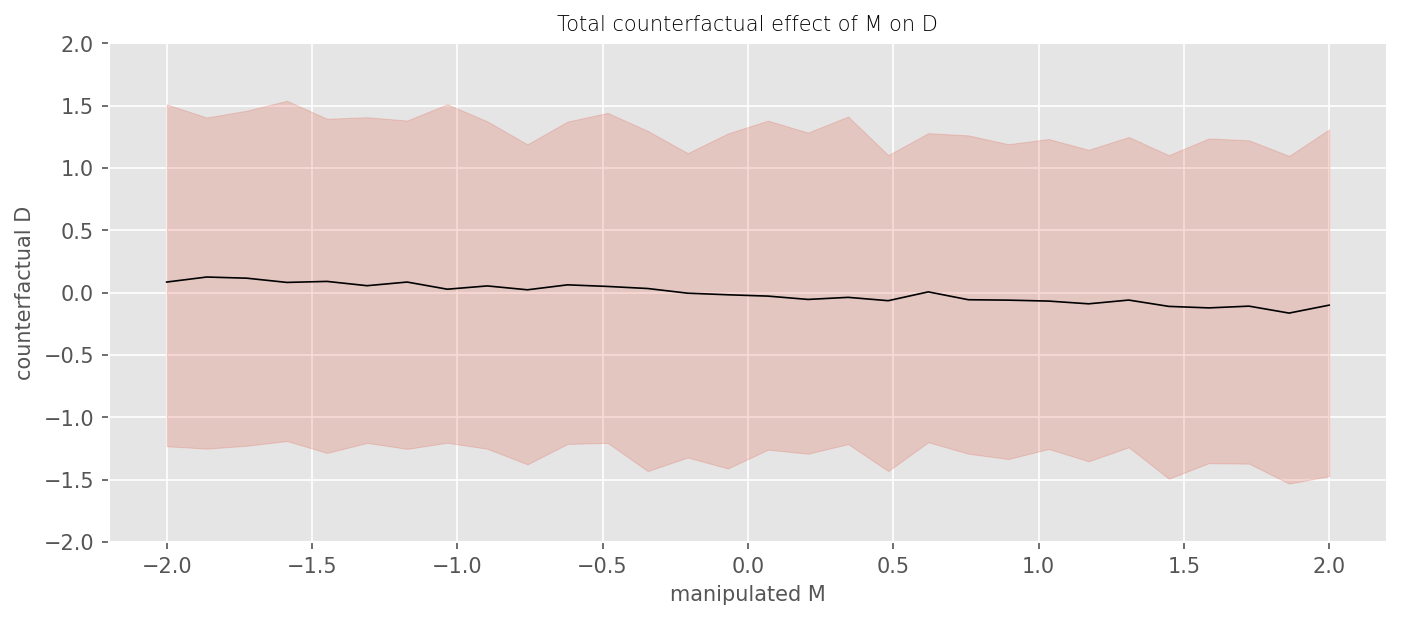

In [19]:
sim_dat = dotdict(dict(M=jnp.linspace(-2, 2, 30), A=0, D=None))
D = Predictive(f5_3A, post5_3A, return_sites=["D"], batch_ndims=2) \
              (seed, **sim_dat)["D"].squeeze(0)

ax = plt.subplot()
ax.plot(sim_dat.M, D.mean(0), color="k")
shade(sim_dat.M, hpdi(D, .89), color="C0", ax=ax, alpha=.2)
ax.set(xlabel="manipulated M", ylabel="counterfactual D", 
       title="Total counterfactual effect of M on D", ylim=[-2, 2]);

Figure 5.7. Simulating from `m5_3A` to see the M → D effect, by setting all A's to zero (average age), and setting a sequence of values for M. Now we broke the influence of A on M, and turns out this also removes the association between M and D. So conclusion: M → D effect is small.

**Note**: I think McElreath went to great lengths here to show that `dag5_1` is not true with `m5_3A`, even if he already did that with `m5_3`. `m5_3A` is a realization of `dag5_1`, and after fitting to the data, intervening on M, and producing the counterfactual plot, we conclude that `M -> D` is not present in this learned model `m5_3A`. 

In [ ]:
"""
with m5_3A:
    M_seq = np.linspace(-2, 2, 30)
    M.set_value(M_seq)
    A.set_value(np.zeros(30))
    mu_D = a + bM*M + bA*A # was a + bM*M_rv + bA*A before sampling the posteriors
    D_sim = pm.Normal("D_sim", mu_D, sigma, shape=mu_D.shape)
    ppd = pm.sample_posterior_predictive(trace5_3A, var_names=["D_sim"]).posterior_predictive
"""

### Code 5.24 - 5.26 (skipped)
To compute ppd of `D` as per Code 5.15 but with explicit tensor ops.

## Section 5.2. Masked relationship

A second reason for a multiple regression model is to measure the direct influences of multiple predictors on an outcome, when none of those influences are apparent given their respective simple regression estimates. This tends to occur when two or more predictors are correlated with one another, and when one is positive correlated with the outcome, and the other one negatively. 

Now we're gonna look at the composition of milk across primate species, and try to relate that to other facts about the species.

### Code 5.27 (read milk data)

In [20]:
d = data("milk")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


A popular hypothesis has it that primates with larger brains produce more energetic
milk, so that brains can grow quickly; 

As in previous examples, standardizing
helps us both get a reliable approximation of the posterior as well as build reasonable priors. The outcome variable here is the energy density of milk, `kcal.per.g`.

### Code 5.28 (standardizing)
Standardizing helps us build reasonable priors.

In [22]:
d.mass = np.log(d.mass)
d[["K", "N", "M"]] = scale(d[["kcal.per.g", "neocortex.perc", "mass"]])

### Code 5.29 (`m5_5_draft`)
We still need to think more about the priors, but let's just fit a model with vague priors first.

In [31]:
def f5_5_draft(N, K=None):
    a = sample("a", dist.Normal(0, 1))
    bN = sample("bN", dist.Normal(0, 1))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bN*N)
    sample("K", dist.Normal(mu, sigma), obs=K)
    
m5_5_draft = AutoLaplaceApproximation(f5_5_draft)
p5_5_draft = (SVI(f5_5_draft, m5_5_draft, Adam(.1), Trace_ELBO())
                 .run(seed, 2000, 
                      N=d.N.values, K=d.K.values).params
             )

ValueError: Normal distribution got invalid loc parameter.

This error message means the model didn't return a valid probability for even the starting parameter values.

Interestingly, the variable that has missing values is N, but the error message indicates `mu` has NaN values, hmm. Take a look inside `d`:

### Code 5.30 (check missing `N` values)

In [32]:
d["neocortex.perc"].to_numpy()

array([55.16,   nan,   nan,   nan,   nan, 64.54, 64.54, 67.64,   nan,
       68.85, 58.85, 61.69, 60.32,   nan,   nan, 69.97,   nan, 70.41,
         nan, 73.4 ,   nan, 67.53,   nan, 71.26, 72.6 ,   nan, 70.24,
       76.3 , 75.49])

When a `np.nan` is passed to a likelihood function, it does not know what to do. After all, what's the probability of a missing value? An easy fix is a **complete case analysis**, meaning drop all rows in `d` with any `np.nan` in it. In later chapters, we will see why this is not good.

### Code 5.31 (complete case analysis)

In [33]:
dcc = d.dropna(how="any", axis=0).copy()

### Code 5.32 (`m5_5_draft` with `dcc`)

In [34]:
dat = dict(K=dcc.K.values, N=dcc.N.values)
p5_5_draft = (SVI(f5_5_draft, m5_5_draft, 
                  Adam(.1), Trace_ELBO(), **dat)
                 .run(seed, 2000).params)

100%|█████████████████████████| 2000/2000 [00:00<00:00, 3008.36it/s, init loss: 58.7295, avg. loss [1901-2000]: 20.8906]


 As in many simple
linear regression problems, these priors are harmless. But are they reasonable? It is important to build reasonable priors, because as the model becomes less simple, the priors can
be very helpful, but only if they are scientifically reasonable.

### Code 5.33 (`m5_5_draft` prior slopes)

In [39]:
n_samples = 50
N_seq = jnp.array([-2., 2.])
mu = Predictive(f5_5_draft, num_samples=n_samples, return_sites=["mu"]) \
               (seed, N=N_seq)["mu"]

fig, ax = plt.subplots(1, 2)
for i in range(n_samples):
    ax[0].plot(N_seq, mu[i], color="C0", alpha=0.3)
ax[0].set(xlabel="neocortex percent (std)", ylabel="kilocal per g (std)", ylim=N_seq, xlim=N_seq)
ax[0].set_title("a ~ dnorm(0, 1)\nbN ~ dnorm(0, 1)", fontsize=10, fontweight=None)
plt.close()

The output plot of Code 5.33 is delayed till after Code 5.34. (Figure 5.8)

The left plot in Figure 5.8 is clearly silly, because after standardizing we should always have our regression line pass through the origin. ("average x implies average y"). And we don't like some of the extreme slopes. How to do better: tightening $\alpha$ so that it's closer to 0. Tighter slope prior for more regularization.

### Code 5.34 (`m5_5` tighter priors)

In [40]:
def f5_5(N, K=None):
    a = sample("a", dist.Normal(0, .2))
    bN = sample("bN", dist.Normal(0, .5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bN*N)
    sample("K", dist.Normal(mu, sigma), obs=K)
    
m5_5 = AutoLaplaceApproximation(f5_5)
p5_5 = (SVI(f5_5, m5_5, Adam(.1), Trace_ELBO())
           .run(seed, 1000, **dat).params)

100%|██████████████████████████| 1000/1000 [00:00<00:00, 2038.12it/s, init loss: 62.1258, avg. loss [951-1000]: 18.7103]


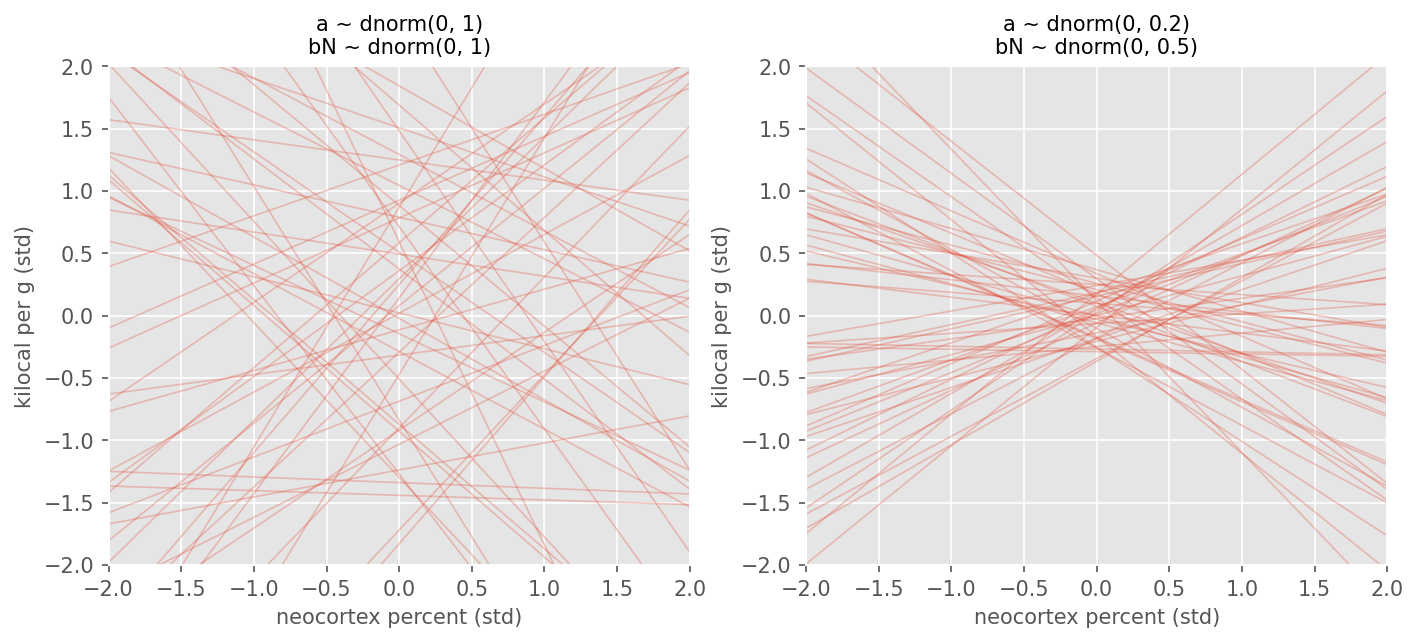

In [42]:
mu = Predictive(f5_5, num_samples=n_samples, return_sites=["mu"]) \
               (seed, N=N_seq)["mu"]
    
for i in range(n_samples):
    ax[1].plot(N_seq, mu[i], color="C0", alpha=0.3)
ax[1].set(xlabel="neocortex percent (std)", ylabel="kilocal per g (std)", ylim=N_seq, xlim=N_seq)
ax[1].set_title("a ~ dnorm(0, 0.2)\nbN ~ dnorm(0, 0.5)", fontsize=10, fontweight=None)
fig

Figure 5.8. Prior predictive distributions for the first primate milk model. 

Left: silly. Right: slightly less silly priors that stay within the potential space of observations.

### Code 5.35 (`m5_5` posterior summary)
Now let's look at the posterior

In [43]:
post5_5 = m5_5.sample_posterior(seed, p5_5, (1, 1000))
precis(post5_5, pars=["a", "bN", "sigma"])

,mean,sd,5.5%,94.5%
a,-0.03,0.16,-0.27,0.23
bN,0.23,0.26,-0.20,0.60
sigma,0.99,0.20,0.66,1.27


You might not get why `m5_5` is not a good fit just from the above table. Let's plot the mean reponse of `K ~ N` over a sequence of `N`, to the upper left of Figure 5.9.

### Code 5.36 (`m5_5` N_seq ppd) 

In [79]:
N_seq = jnp.linspace(dcc.N.min() - 0.15, dcc.N.max() + 0.15, 30)
mu = Predictive(f5_5, post5_5, return_sites=["mu"], batch_ndims=2) \
               (seed, N=N_seq)["mu"].squeeze(0)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(N_seq, mu.mean(0), color="k")
scatter(dcc.N, dcc.K, ax=ax[0, 0], s=100, alpha=1)
ax[0, 0].set(xlabel="neocortex percent (std)", ylabel="kilocal per g (std)")
shade(N_seq, hpdi(mu, .89), ax=ax[0, 0], alpha=.2, color="C0")
plt.close()

From Figure 5.9, a lot of mildly positive and negative slopes are still plausible given `m5_5` and the data. It is imprecise.

### Code 5.37 (`m5_6`)

Now consider `K ~ log(mass)`. Note: we have already converted `mass` into `M` by taking logarithm and standardizing.  

In [95]:
def f5_6(M, K=None):
    a = sample("a", dist.Normal(0, .2))
    bM = sample("bM", dist.Normal(0, .5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bM*M)
    sample("K", dist.Normal(mu, sigma), obs=K)
    
dat = dict(M=dcc.M.values, K=dcc.K.values)
m5_6 = AutoLaplaceApproximation(f5_6)
p5_6 = (SVI(f5_6, m5_6, Adam(.1), Trace_ELBO())
           .run(seed, 2000, **dat).params)
post5_6 = m5_6.sample_posterior(seed, p5_6, (1, 1000))
precis(post5_6, pars=["a", "bM", "sigma"])

100%|█████████████████████████| 2000/2000 [00:00<00:00, 2075.77it/s, init loss: 48.8704, avg. loss [1901-2000]: 18.5837]


,mean,sd,5.5%,94.5%
a,0.01,0.15,-0.24,0.26
bM,-0.22,0.24,-0.61,0.13
sigma,0.99,0.20,0.66,1.26


Log body mass is negatively associated with milk energy. Now this association seems to be stronger than that between neocortex percentage and milk energy. The posterior regression plot is shown in the upper right of Figure 5.9.

In [80]:
M_seq = jnp.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, len(dcc))
mu = Predictive(f5_6, post5_6, return_sites=["mu"], batch_ndims=2) \
               (seed, M=M_seq)["mu"].squeeze(0)

ax[0, 1].plot(M_seq, mu.mean(0), color="k")
scatter(dcc.M, dcc.K, ax=ax[0, 1], s=100, alpha=1)
shade(M_seq, hpdi(mu, .89), ax=ax[0, 1], color="C0", alpha=.2)
ax[0, 1].set(xlabel="log body mass (std)", ylabel="kilocal per g (std)");

### Code 5.38 (`m5_7`, both predictors)

In [68]:
def f5_7(M, N, K=None):
    a = sample("a", dist.Normal(0, .2))
    bM = sample("bM", dist.Normal(0, .5))
    bN = sample("bN", dist.Normal(0, .5))
    sigma = sample("sigma", dist.Exponential(1))
    mu = deterministic("mu", a + bM*M + bN*N)
    sample("K", dist.Normal(mu, sigma), obs=K)
    
m5_7 = AutoLaplaceApproximation(f5_7)
dat = dict(M=dcc.M.values, N=dcc.N.values, K=dcc.K.values)
p5_7 = (SVI(f5_7, m5_7, Adam(.1), Trace_ELBO())
           .run(seed, 2000, **dat).params)
post5_7 = m5_7.sample_posterior(seed, p5_7, (1, 1000))
precis(post5_7, pars=["a", "bM", "bN", "sigma"])

100%|█████████████████████████| 2000/2000 [00:00<00:00, 2450.55it/s, init loss: 36.8399, avg. loss [1901-2000]: 17.3257]


,mean,sd,5.5%,94.5%
a,-0.03,0.15,-0.28,0.22
bM,-0.50,0.24,-0.87,-0.11
bN,0.52,0.26,0.10,0.92
sigma,0.82,0.17,0.55,1.05


### Code 5.39 (`plot_forest` for `m5_6` and `m5_7`)

By incorporating both predictors, the posterior association of both with the outcome has increased. The `bN` estimate increased 5-fold, while the `bM` estimamte increased 2.5 times.

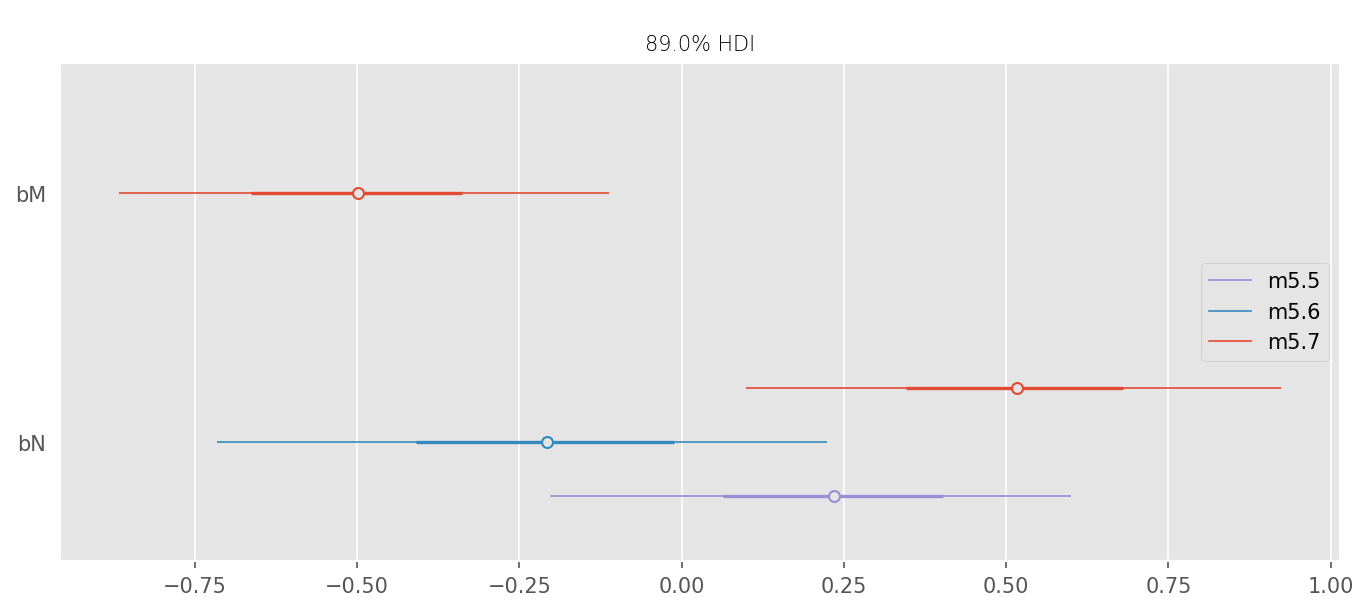

In [70]:
_, ax1 = plt.subplots()
az.plot_forest([post5_7, post5_6, post5_5],
                model_names=["m5.7", "m5.6", "m5.5"],
                var_names=["bM", "bN"],
                combined=True, ax = ax1);

Look at pairwise scatterplots to further appreciate.

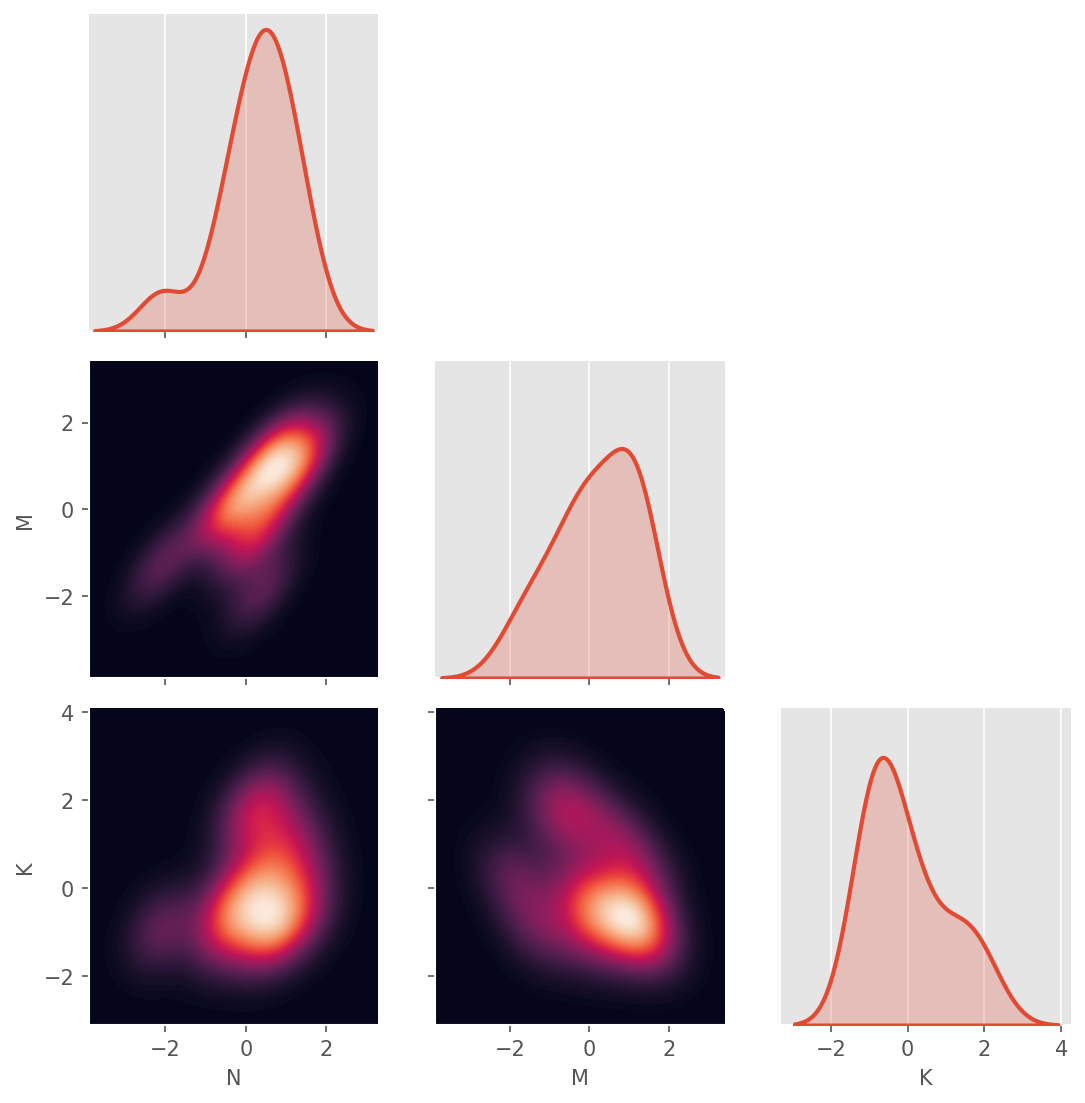

In [71]:
g = sns.PairGrid(dcc[["N", "M", "K"]], corner=True)
g.map_lower(sns.kdeplot, cmap="rocket", thresh=0, levels=100, fill=True)
g.map_diag(sns.kdeplot, lw=2, fill=True);

The pairwise plots tell us if only looking at one predictor v. the outcome, then it is hard to conclude any strong association. In our case, higher body mass comes with higher neocortex percentage. But body mass and neocortex percentage are each correlated with milk energy in opposite ways. That explains the weak posteriors from `m5_5` and `m5_6`.

There are at least 3 DAGs consistent with the pattern in these data:

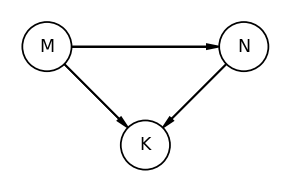

In [72]:
dag5_2a = init_dag()
dag5_2a.add_node("M", "M", -1, 1)
dag5_2a.add_node("N", "N", 1, 1)
dag5_2a.add_node("K", "K", 0, 0)
dag5_2a.add_edge("M", "K")
dag5_2a.add_edge("N", "K")
dag5_2a.add_edge("M", "N")
dag5_2a.show();

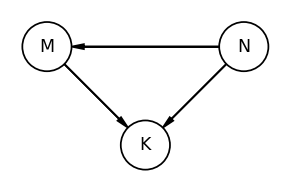

In [73]:
dag5_2b = init_dag()
dag5_2b.add_node("M", "M", -1, 1)
dag5_2b.add_node("N", "N", 1, 1)
dag5_2b.add_node("K", "K", 0, 0)
dag5_2b.add_edge("M", "K")
dag5_2b.add_edge("N", "K")
dag5_2b.add_edge("N", "M")
dag5_2b.show();

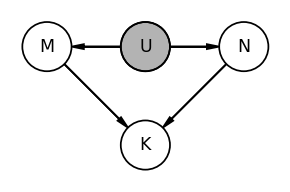

In [74]:
dag5_2b = init_dag()
dag5_2b.add_node("M", "M", -1, 1)
dag5_2b.add_node("N", "N", 1, 1)
dag5_2b.add_node("K", "K", 0, 0)
dag5_2b.add_node("U", "U", 0, 1, alternate=True)
dag5_2b.add_edge("M", "K")
dag5_2b.add_edge("N", "K")
dag5_2b.add_edge("U", "M")
dag5_2b.add_edge("U", "N")
dag5_2b.show();

Which of these DAGs are right? We cannot tell from data alone, because they all imply the same sets of conditional independencies (None). We call such group of DAGs a **Markov equivalence** set. Then you should use some extra knowledge to determine which DAGs are wrong.

### Code 5.40 (`m5_7` counterfactual plots)

The final thing we'd like to do with these models is to finish Figure 5.9 and make counterfactual plots. Here is the code to produce the lower left.

In [81]:
dat = dotdict(dict(M=jnp.linspace(dcc.M.min() - 0.15, dcc.M.max() + 0.15, 30),
                   N=0))
mu = Predictive(f5_7, post5_7, batch_ndims=2, return_sites=["mu"]) \
               (seed, **dat)["mu"].squeeze(0)
ax[1, 1].plot(dat.M, mu.mean(0), color="k")
shade(dat.M, hpdi(mu, .89), ax=ax[1, 1], color="C0", alpha=.2)
ax[1, 1].set(xlabel="log body mass (std)", ylabel="kilocal per g (std)");

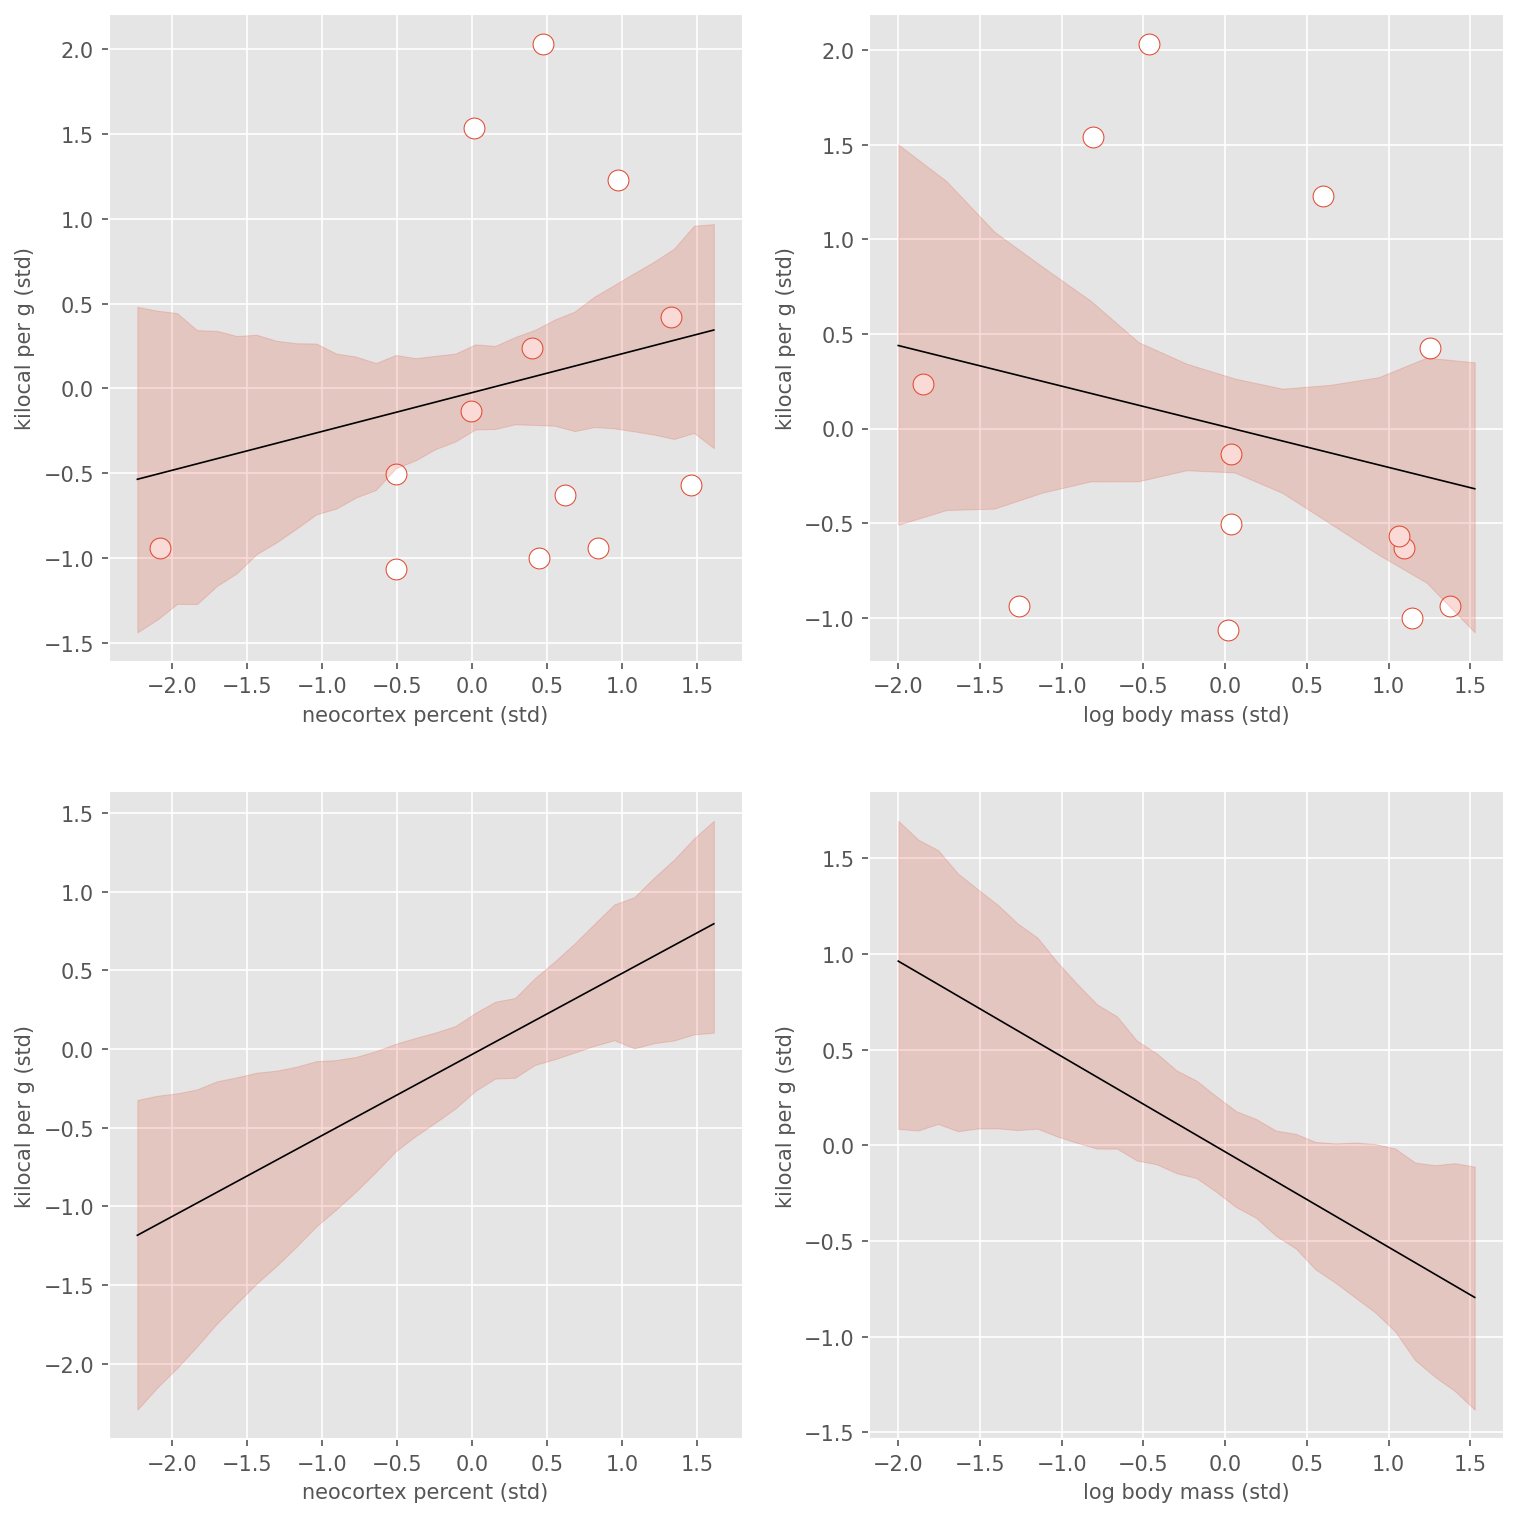

In [82]:
dat = dotdict(dict(N=jnp.linspace(dcc.N.min() - 0.15, dcc.N.max() + 0.15, 30),
                   M=0))
mu = Predictive(f5_7, post5_7, batch_ndims=2, return_sites=["mu"]) \
               (seed, **dat)["mu"].squeeze(0)
ax[1, 0].plot(dat.N, mu.mean(0), color="k")
shade(dat.N, hpdi(mu, .89), ax=ax[1, 0], color="C0", alpha=.2)
ax[1, 0].set(xlabel="neocortex percent (std)", ylabel="kilocal per g (std)")
fig

Figure 5.9. In nature, changing one predictor will change other predictors as well, so these counterfactual plots are to be taken with a grain of salt. But these plots do help us see how the model views the association between each predictor and the outcome. Top left and right: simple regression mean plots. Bottom left and right: regression with both `M` and `N` counterfactual plots (the other covariate set constant). **Note how the bottom plots show stronger associations**.

## Code 5.41 (simulate a masked relationship, `dag5_2a`)

After creating the simulated data (`dag5_2a`), looking at the `az.summary()` outputs you can see the same masking pattern from the `dcc` data.

In [103]:
# M -> K <- N
# M -> N
n = 100
M = rnorm(size=100)
N = rnorm(size=100, mu=M)
K = rnorm(size=100, mu=N-M)

dat = dict(N=N, K=K)
p5_5_ = (SVI(f5_5, m5_5, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_5_ = m5_5.sample_posterior(seed, p5_5_, (1, 1000))
precis(post5_5_, pars=["bN"])

100%|███████████████████████| 3000/3000 [00:01<00:00, 1860.24it/s, init loss: 952.8335, avg. loss [2851-3000]: 152.5035]


,mean,sd,5.5%,94.5%
bN,0.5,0.28,0.03,0.92


In [99]:
dat = dict(M=M, K=K)
p5_6_ = (SVI(f5_6, m5_6, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_6_ = m5_6.sample_posterior(seed, p5_6_, (1, 1000))
precis(post5_6_, pars=["bM"])

100%|███████████████████████| 3000/3000 [00:01<00:00, 1883.51it/s, init loss: 446.0733, avg. loss [2851-3000]: 170.8550]


,mean,sd,5.5%,94.5%
bM,0.02,0.31,-0.51,0.48


In [100]:
dat = dict(M=M, N=N, K=K)
p5_7_ = (SVI(f5_7, m5_7, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_7_ = m5_7.sample_posterior(seed, p5_7_, (1, 1000))
precis(post5_7_, pars=["bM", "bN"])

100%|███████████████████████| 3000/3000 [00:01<00:00, 1599.06it/s, init loss: 243.7671, avg. loss [2851-3000]: 121.6309]


,mean,sd,5.5%,94.5%
bM,-1.04,0.24,-1.43,-0.68
bN,1.00,0.24,0.60,1.37


### Code 5.42 (`dag5_2b`, `dag5_2c` simulations)

In [105]:
# M -> K <- N
# N -> M
n = 100
N = rnorm(size=n)
M = rnorm(size=n, mu=N)
K = rnorm(size=n, mu=N-M)

In [106]:
dat = dict(N=N, K=K)
p5_5_ = (SVI(f5_5, m5_5, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_5_ = m5_5.sample_posterior(seed, p5_5_, (1, 1000))
precis(post5_5_, pars=["bN"])

100%|███████████████████████| 3000/3000 [00:00<00:00, 3308.14it/s, init loss: 463.9391, avg. loss [2851-3000]: 179.8530]


,mean,sd,5.5%,94.5%
bN,0.0,0.35,-0.57,0.51


In [107]:
dat = dict(M=M, K=K)
p5_6_ = (SVI(f5_6, m5_6, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_6_ = m5_6.sample_posterior(seed, p5_6_, (1, 1000))
precis(post5_6_, pars=["bM"])

100%|███████████████████████| 3000/3000 [00:00<00:00, 3219.16it/s, init loss: 463.6939, avg. loss [2851-3000]: 165.8745]


,mean,sd,5.5%,94.5%
bM,-0.46,0.29,-0.96,-0.03


In [108]:
dat = dict(M=M, N=N, K=K)
p5_7_ = (SVI(f5_7, m5_7, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_7_ = m5_7.sample_posterior(seed, p5_7_, (1, 1000))
precis(post5_7_, pars=["bM", "bN"])

100%|███████████████████████| 3000/3000 [00:00<00:00, 3138.82it/s, init loss: 243.4723, avg. loss [2851-3000]: 148.9214]


,mean,sd,5.5%,94.5%
bM,-0.94,0.28,-1.39,-0.52
bN,0.92,0.29,0.46,1.37


In [109]:
# M -> K <- N
# M <- U -> N
n = 100
U = rnorm(n)
N = rnorm(n, mu=U)
M = rnorm(n, mu=U)
K = rnorm(n, mu=N-M)

In [110]:
dat = dict(N=N, K=K)
p5_5_ = (SVI(f5_5, m5_5, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_5_ = m5_5.sample_posterior(seed, p5_5_, (1, 1000))
print(precis(post5_5_, pars=["bN"]))

dat = dict(M=M, K=K)
p5_6_ = (SVI(f5_6, m5_6, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_6_ = m5_6.sample_posterior(seed, p5_6_, (1, 1000))
print(precis(post5_6_, pars=["bM"]))

dat = dict(M=M, N=N, K=K)
p5_7_ = (SVI(f5_7, m5_7, Adam(.1), Trace_ELBO())
            .run(seed, 3000, **dat).params)
post5_7_ = m5_7.sample_posterior(seed, p5_7_, (1, 1000))
print(precis(post5_7_, pars=["bM", "bN"]))

100%|███████████████████████| 3000/3000 [00:00<00:00, 3240.28it/s, init loss: 918.5059, avg. loss [2851-3000]: 184.2231]


    mean    sd  5.5%  94.5%
bN  0.49  0.34 -0.09   0.99


100%|███████████████████████| 3000/3000 [00:00<00:00, 3284.67it/s, init loss: 445.0768, avg. loss [2851-3000]: 186.4726]


    mean    sd  5.5%  94.5%
bM -0.43  0.33 -0.99   0.05


100%|███████████████████████| 3000/3000 [00:01<00:00, 2939.49it/s, init loss: 242.3766, avg. loss [2851-3000]: 147.2681]


    mean    sd  5.5%  94.5%
bM -1.02  0.28 -1.47   -0.6
bN  0.98  0.28  0.50    1.4


All three simulations lead to the same findings.

To wrap up the milk data, it's okay to come up with a story like: bigger animals tend to live longer, and animals that live longer tend to invest more in learning, thus developing their neocortexes more. This story implies that `dag5_2a` is right, but just with evidence at hand, we don't know yet.

### Code 5.43 (skipped, get Markov equivalent DAGs)

In [ ]:
#dag5.7 <- dagitty( "dag{
#M -> K <- N
#M -> N }" )
#coordinates(dag5.7) <- list( x=c(M=0,K=1,N=2) , y=c(M=0.5,K=1,N=0.5) )
#MElist <- equivalentDAGs(dag5.7)
#drawdag(MElist)

## Section 5.3. Categorical variables 

### Code 5.44 (read Howell1 data)

In [111]:
d = data("Howell1")
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


### Code 5.45 (simulate Howell1 with dummy male variables)

Consider a linear model `height ~ male` on the Howell dataset as the underlying data generator. The average male height has **a priori** more uncertainty than the average female height. But it does not seem natural to assume a priori more uncertainty in the average male height.

In [112]:
mu_female = rnorm(int(1e4), 178, 20)
mu_male  = rnorm(int(1e4), 178, 20) + rnorm(int(1e4), 0, 10)
precis(dframe({"mu_female": mu_female, "mu_male": mu_male}))

,mean,sd,5.5%,94.5%
mu_female,177.76,19.82,146.24,209.06
mu_male,177.88,22.24,142.44,213.60


Or we can use **index variables** instead of the male dummy.

### Code 5.46 (index variables)

In [120]:
d["sex"] = np.where(d.male == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int64

Now with `sex` being the index variable, the model becomes:

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$

$$\mu_i = \alpha_{\text{SEX[i]}}$$

$$\alpha_j \sim \text{Normal}(178, 20)\text{, for }j=1,2$$

$$\sigma \sim \text{Uniform}(0, 50)$$

And this solves the problem that priors may have different degrees of uncerntainty.

### Code 5.47 (`m5_8`, sex as index)

In [124]:
def f5_8(sex, height=None):
    num_sex = len(set(sex))
    a = sample("a", dist.Normal(178, 20).expand([num_sex]))
    sigma = sample("sigma", dist.Uniform(0, 50))
    mu = a[sex]
    sample("height", dist.Normal(mu, sigma), obs=height)
 

dat = dict(sex=d.sex.values, height=d.height.values)
m5_8 = AutoLaplaceApproximation(f5_8)
p5_8 = (SVI(f5_8, m5_8, Adam(1), Trace_ELBO())
           .run(seed, 3000, **dat).params)
post5_8 = m5_8.sample_posterior(seed, p5_8, (1, 1000))
precis(post5_8, pars=["a", "sigma"])

100%|███████████████████| 3000/3000 [00:01<00:00, 2876.70it/s, init loss: 125371.8984, avg. loss [2851-3000]: 2584.1562]


,mean,sd,5.5%,94.5%
a[0],134.95,1.54,132.50,137.45
a[1],142.69,1.72,139.85,145.22
sigma,27.31,0.84,25.86,28.58


### Code 5.48 (contrast calculation)
Interpreting the posterior table is easy. But often we are interested in differences between categories. Difference in heights between two sexes (**Contrast calculation**):

In [132]:
post5_8["diff_fm"] = post5_8["a"][..., 0] - post5_8["a"][..., 1]
precis(post5_8, pars=["sigma", "a", "diff_fm"])

,mean,sd,5.5%,94.5%
sigma,27.31,0.84,25.86,28.58
a[0],134.95,1.54,132.50,137.45
a[1],142.69,1.72,139.85,145.22
diff_fm,-7.74,2.26,-11.39,-4.36


We'll stick with the index variable approach for a categorical variable with more than two levels. The number of parameters does not change between the index variable and the dummy variable approaches, but the model specification is easier with the index variable approach. Let's again explore the milk dataset.

### Code 5.49 (read milk data)

In [133]:
d = data("milk")
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

Coerce the factor to an integer:

### Code 5.50 (preprocess the categories)

In [134]:
d.clade = d.clade.astype("category")

Let's build a model measuring the average milk energy in each clade. The $\alpha_j$'s priors here are widen to allow the different clades to disperse, if the data wants them to.
$$K_i \sim \text{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha_{\text{CLADE}[i]}$$
$$\alpha_j \sim \text{Normal}(0, 0.5)\text{, for }j=1,\cdots,4$$
$$\sigma \sim \text{Exponential}(1)$$

### Code 5.51 (`m5_9` K v. clades)

In [141]:
d["K"] = scale(d["kcal.per.g"])

def f5_9(clade, K=None):
    num_clades = len(set(clade))
    a = sample("a", dist.Normal(0, .5).expand([num_clades]))
    sigma = sample("sigma", dist.Exponential(1))
    mu = a[clade]
    sample("K", dist.Normal(mu, sigma), obs=K)

    
dat = dict(clade=d.clade.cat.codes.values, 
           K=d.K.values)
m5_9 = AutoLaplaceApproximation(f5_9)
p5_9 = (SVI(f5_9, m5_9, Adam(1), Trace_ELBO())
           .run(seed, 2000, **dat).params)

100%|███████████████████████| 2000/2000 [00:00<00:00, 2800.51it/s, init loss: 1295.3124, avg. loss [1901-2000]: 36.2465]


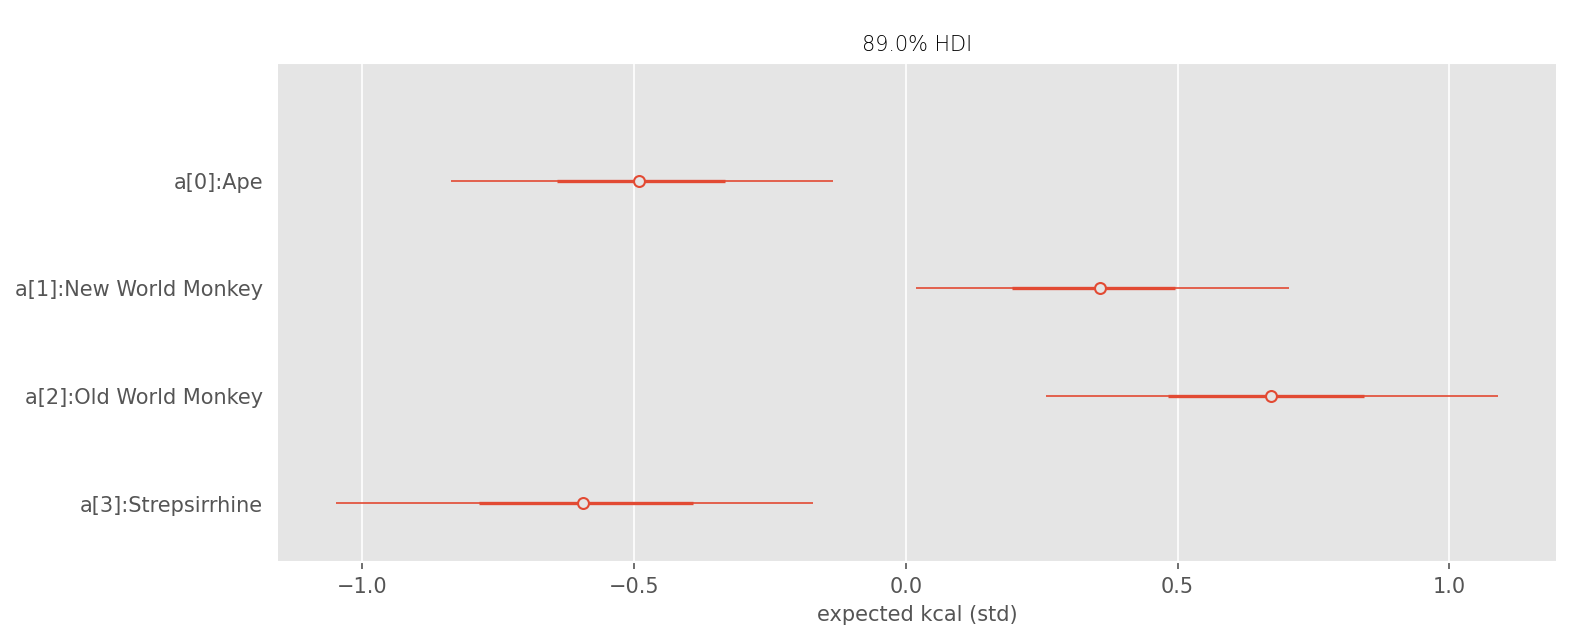

In [156]:
post5_9 = m5_9.sample_posterior(seed, p5_9, (1, 1000))
ax = plt.subplot()
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest(post5_9, var_names=["a"], ax=ax, combined=True)
ax.set(xlabel="expected kcal (std)", 
       yticklabels=labels[::-1]);

If you have another kind of categorical variable, you can use the same approach to add that into your model.

### Code 5.52 (fake categorical)

[1] Gryffindor, [2] Hufflepuff, [3] Ravenclaw, and [4]
Slytherin.


In [140]:
d["house"] = np.random.choice(np.repeat(np.arange(0, 4), repeats=8), size=d.shape[0])

### Code 5.53 (`m5_10` with two cat vars)

In [146]:
def f5_10(clade, house, K=None):
    n_clades, n_houses = len(set(clade)), len(set(house))
    a = sample("a", dist.Normal(0, .5).expand([n_clades]))
    h = sample("h", dist.Normal(0, .5).expand([n_houses]))
    mu = a[clade] + h[house]
    sigma = sample("sigma", dist.Exponential(1))
    sample("K", dist.Normal(mu, sigma), obs=K)
    
dat = dict(clade=d.clade.cat.codes.values, 
           house=d.house.values, K=d.K.values)
m5_10 = AutoLaplaceApproximation(f5_10)
p5_10 = (SVI(f5_10, m5_10, Adam(1), Trace_ELBO())
            .run(seed, 2000, **dat).params)

100%|█████████████████████████| 2000/2000 [00:00<00:00, 2381.99it/s, init loss: 88.5156, avg. loss [1901-2000]: 35.8686]


In [151]:
post5_10 = m5_10.sample_posterior(seed, p5_10, (1, 1000))
precis(post5_10, pars=["h"])

,mean,sd,5.5%,94.5%
h[0],-0.45,0.30,-0.88,0.05
h[1],0.03,0.33,-0.53,0.52
h[2],0.10,0.26,-0.28,0.55
h[3],-0.02,0.27,-0.43,0.43


**Rethinking: Differences and statistical significance.** In general, Group A with an average parameter reliably above zero, and Group B with an average parameter overlapping with zero a lot, do not imply the Group A & B difference will be well off zero. You need to explicit calculate the posterior of the difference. This type of ill thinking pervails in hypothesis testing as well.

## Section 5.4 Summary

In fitting a multiple regression model, we ask the question of: _what is the value of adding one extra variable given the existence of other variables in the model?_ Implicit in this question are: (1) a focus on fitting the model to describe the observed sample. (2) the assumption that the predictors are independent with each other. (if dependent, always good to know more). Later chapters will confront these issues.

In [159]:
%reload_ext watermark
%watermark -v -iv -u -n -t

Last updated: Fri Apr 21 2023 22:02:39

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.12.0

pandas    : 2.0.0
seaborn   : 0.12.2
xarray    : 2023.4.2
jax       : 0.4.8
numpyro   : 0.11.0
arviz     : 0.15.1
matplotlib: 3.7.1
autograd  : 1.5



In [164]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


In [3]:
!apt search cudnn | grep installed



cudnn-local-repo-ubuntu2204-8.9.0.131/now 1.0-1 amd64 [installed,local]
libcudnn8/unknown,now 8.9.0.131-1+cuda12.1 amd64 [installed]
libcudnn8-dev/unknown,now 8.9.0.131-1+cuda12.1 amd64 [installed]
libcudnn8-samples/unknown,now 8.9.0.131-1+cuda12.1 amd64 [installed]
